In [31]:
# importing modules
import os
import cv2

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC

In [2]:
tf.version.VERSION

'2.10.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
DATASET_PATH = './datasets/model_data'

IMG_W = 256
IMG_H = 72
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50

input_shape = (IMG_H, IMG_W, CHANNELS)

weight_decay = 0.005
learning_rate = 0.05
lr_decay = 1e-6
lr_drop = 25

## Dataset Loading

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    f'{DATASET_PATH}/train',
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 780 images belonging to 15 classes.


In [6]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    f'{DATASET_PATH}/val',
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 91 images belonging to 15 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    f'{DATASET_PATH}/test',
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 111 images belonging to 15 classes.


In [8]:
for image_batch, label_batch in train_generator:
    print(image_batch.shape)
    break

(32, 72, 256, 3)


## Plotting

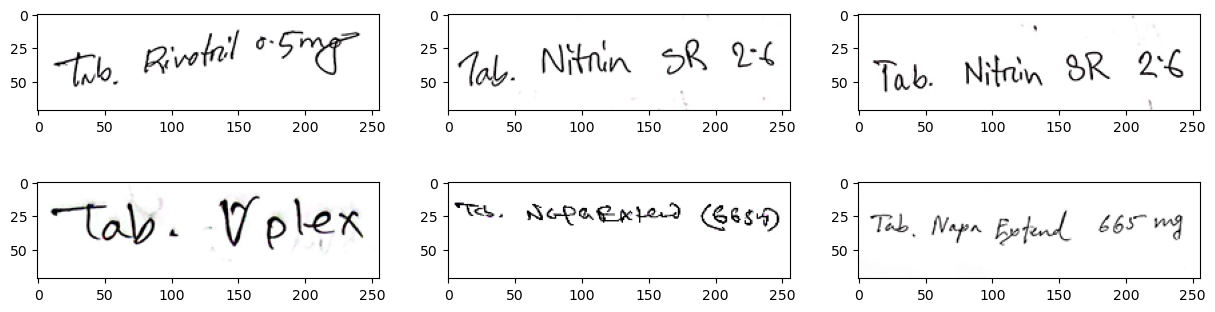

In [9]:
images, labels = train_generator.next()
plt.figure(figsize=(15, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray')
plt.show()

In [27]:
def plot_accuracy(history, model_name=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(25, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(50), acc, label='Training Accuracy')
    plt.plot(range(50), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(
        f'Training and Validation Accuracy {f"for {model_name}" if model_name else ""}')

    plt.subplot(1, 2, 2)
    plt.plot(range(50), loss, label='Training Loss')
    plt.plot(range(50), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(
        f'Training and Validation Loss {f"for {model_name}" if model_name else ""}')
    plt.savefig('./figures/model_accuracy.png')
    plt.show()

## Model Training

In [11]:
model = tf.keras.models.Sequential([
    # Conv 1
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    # Conv 2
    Conv2D(64,  kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    # Conv 3
    Conv2D(96,  kernel_size=(4, 4), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    # Conv 4
    Conv2D(96, (4, 4), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    # Conv 5
    Conv2D(96, (4, 4), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    # Conv 6
    Conv2D(128, (4, 4), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(38, activation='softmax')
])

In [12]:
model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 254, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 127, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 63, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 17, 63, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 63, 96)        9

In [63]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [64]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_generator
)

Epoch 1/50
25/25 [==============================] - 3s 72ms/step - loss: 0.0539 - accuracy: 0.9859 - val_loss: 0.0706 - val_accuracy: 0.9670
Epoch 2/50
25/25 [==============================] - 2s 66ms/step - loss: 0.0612 - accuracy: 0.9821 - val_loss: 0.1980 - val_accuracy: 0.9341
Epoch 3/50
25/25 [==============================] - 2s 71ms/step - loss: 0.0565 - accuracy: 0.9808 - val_loss: 0.1494 - val_accuracy: 0.9560
Epoch 4/50
25/25 [==============================] - 2s 73ms/step - loss: 0.0798 - accuracy: 0.9795 - val_loss: 0.1575 - val_accuracy: 0.9560
Epoch 5/50
25/25 [==============================] - 2s 74ms/step - loss: 0.0285 - accuracy: 0.9910 - val_loss: 0.1162 - val_accuracy: 0.9560
Epoch 6/50
25/25 [==============================] - 2s 63ms/step - loss: 0.0302 - accuracy: 0.9923 - val_loss: 0.0898 - val_accuracy: 0.9560
Epoch 7/50
25/25 [==============================] - 2s 62ms/step - loss: 0.0413 - accuracy: 0.9872 - val_loss: 0.2706 - val_accuracy: 0.9011
Epoch 8/50
25

In [ ]:
scores = model.evaluate(test_generator)
scores

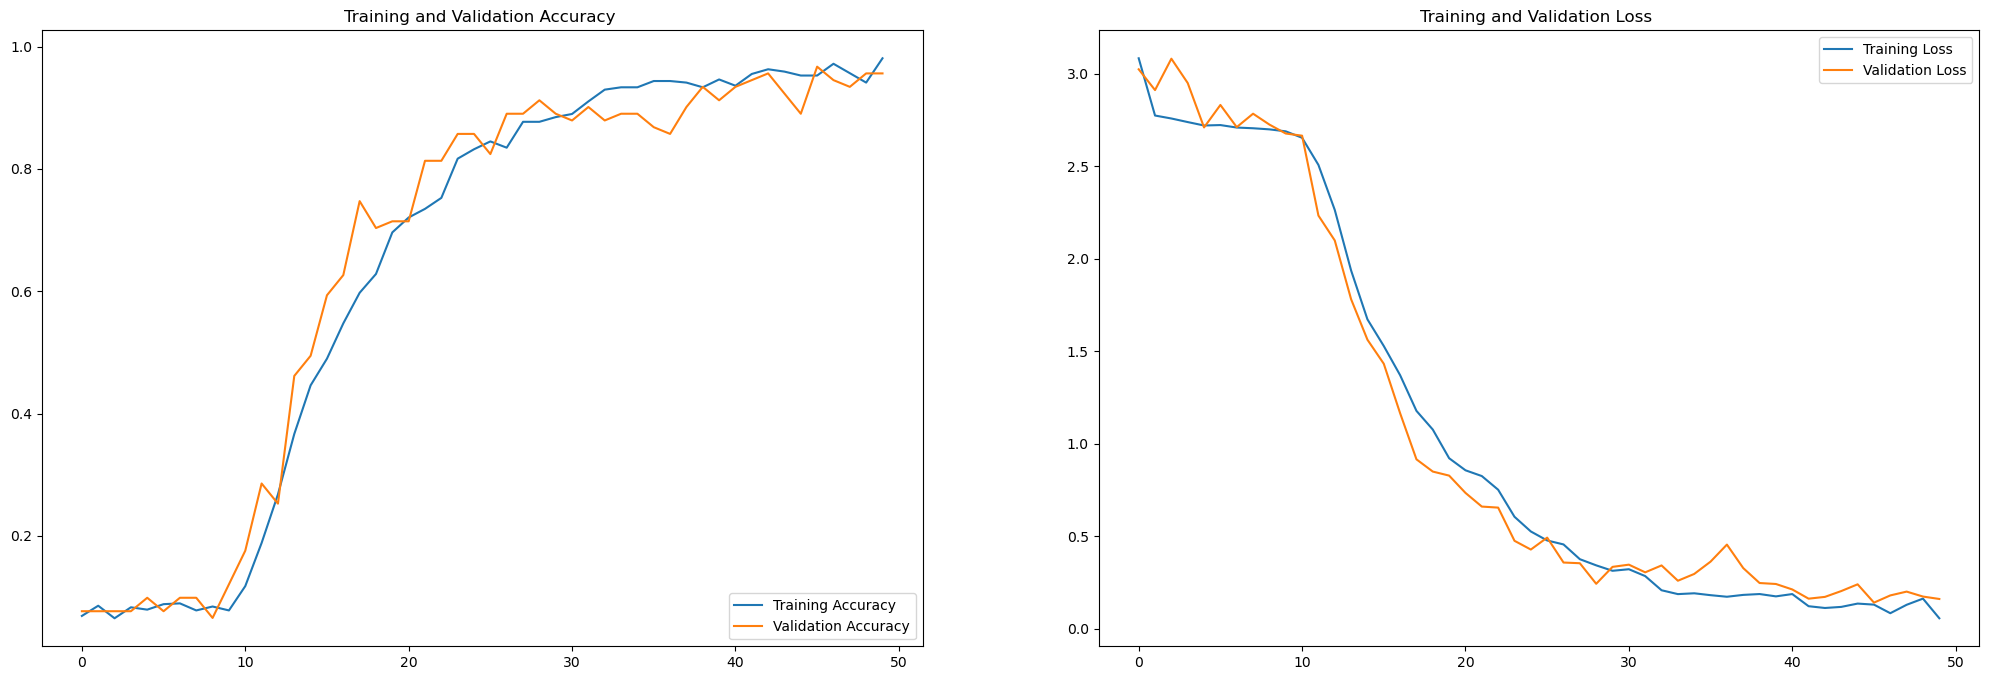

In [30]:
plot_accuracy(history)

In [18]:
class_names = list(train_generator.class_indices.keys())
class_names

['Tab. Afenac 50mg',
 'Tab. Calcin D',
 'Tab. Finix 20mg',
 'Tab. Fixal 120mg',
 'Tab. Napa Extend 665mg',
 'Tab. Naprosyn 500mg',
 'Tab. Napsod 550mg',
 'Tab. Nitrin SR 2.6mg',
 'Tab. Osartil 100mg',
 'Tab. Ovocal-DX',
 'Tab. Ramoril 5mg',
 'Tab. Resva 5mg',
 'Tab. Rivotril 0.5mg',
 'Tab. Riz 10mg',
 'Tab. V-Plex']

In [19]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [20]:
img = r"D:\CSE400\porjects\docs-handwriting-recognizer\model\datasets\model_data\test\Tab. Riz 10mg\7.png"
img = cv2.imread(img)
predict(model, img)

1/1 [==============================] - 0s 315ms/step


('Tab. Riz 10mg', 100.0)

In [22]:
model_version = max([int(i) for i in os.listdir('save_models') + [0]]) + 1
model.save(f'./save_models/{model_version}')
model.save(f'./h5/model_{model_version}.h5')

INFO:tensorflow:Assets written to: ./save_models/2\assets


INFO:tensorflow:Assets written to: ./save_models/2\assets
